# CS 178 Project: Sentiment Analysis on IMDB Movie Reviews

**Authors:** Arun Malani, Brock Allan, Nathan Chau

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(1234)

PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"


In [40]:
def load_reviews(directory, label=None):
    reviews = []
    if not directory.exists():
        return reviews
    for file_path in directory.glob("*.txt"):
        name_without_ext = file_path.stem
        parts = name_without_ext.split('_')
        if len(parts) == 2:
            file_id, rating = parts
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            reviews.append((text, label, int(file_id), int(rating)))
    return reviews

def load_dataset():
    train_pos = load_reviews(TRAIN_DIR / "pos", label="pos")
    train_neg = load_reviews(TRAIN_DIR / "neg", label="neg")
    train_data = train_pos + train_neg
    
    test_pos = load_reviews(TEST_DIR / "pos", label="pos")
    test_neg = load_reviews(TEST_DIR / "neg", label="neg")
    test_data = test_pos + test_neg
    return train_data, test_data

train_data, test_data = load_dataset()


In [41]:
train_df = pd.DataFrame(train_data, columns=['text', 'label', 'file_id', 'rating'])
test_df = pd.DataFrame(test_data, columns=['text', 'label', 'file_id', 'rating'])

## 1. EDA

###

## 2. Problem

### Research Question

Can we accurately classify movie reviews as positive or negative using machine learning techniques?

### Evaluation Metrics

We evaluate models using accuracy and precision + recall.

## 3. Models

#### 3.1 Feature Extraction

We use CountVectorizer to convert text into numerical features using word frequencies with n-grams.

In [42]:
X_train_text = train_df['text'].values
y_train = train_df['label'].values
X_test_text = test_df['text'].values
y_test = test_df['label'].values

y_train_binary = (y_train == 'pos').astype(int)
y_test_binary = (y_test == 'pos').astype(int)

In [43]:
vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)
feature_names = vectorizer.get_feature_names_out()


#### 3.2 Random Forest Baseline


In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=1234,
    n_jobs=-1,
    verbose=0
)

rf_baseline.fit(X_train_vec, y_train_binary)

y_train_pred = rf_baseline.predict(X_train_vec)
y_test_pred = rf_baseline.predict(X_test_vec)

train_accuracy = accuracy_score(y_train_binary, y_train_pred)
test_accuracy = accuracy_score(y_test_binary, y_test_pred)

print(f"train accuracy: {train_accuracy:.4f}, test accuracy: {test_accuracy:.4f}")


train accuracy: 1.0000, test accuracy: 0.8471


#### 3.3 Manual Hyperparameter Exploration


In [45]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
train_idx, val_idx = next(sss.split(X_train_vec, y_train_binary))

X_train_subset = X_train_vec[train_idx]
y_train_subset = y_train_binary[train_idx]
X_val_subset = X_train_vec[val_idx]
y_val_subset = y_train_binary[val_idx]


#### 3.4 Exploring max_depth


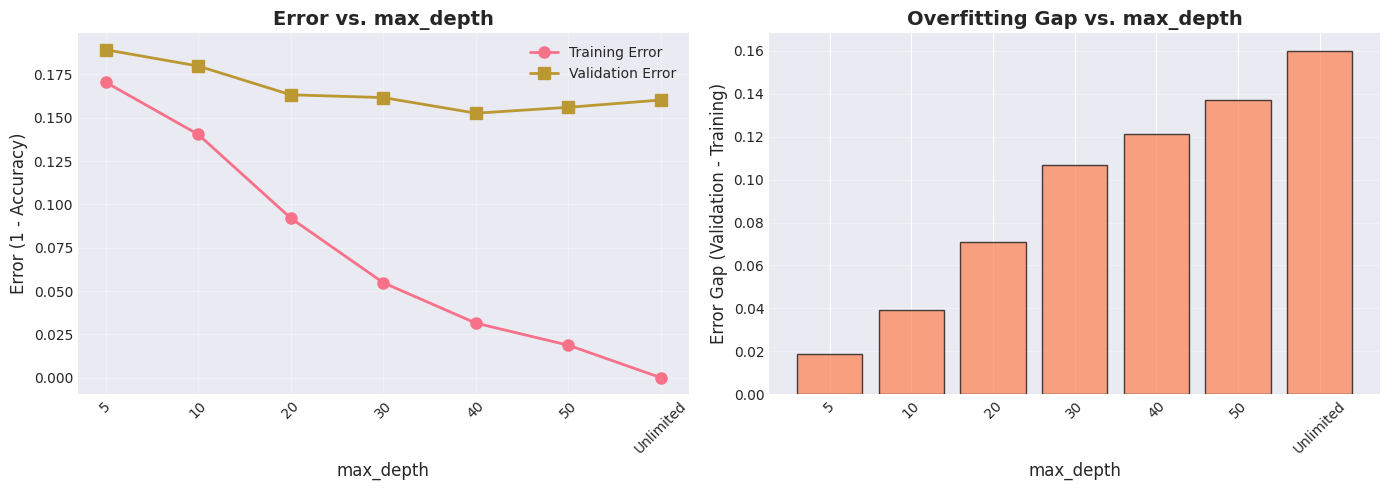

In [ ]:
max_depths = [5, 10, 20, 30, 40, 50, None]
depth_results = {'depth': [], 'train_err': [], 'val_err': [], 'gap': []}

for depth in max_depths:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=depth,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    depth_results['depth'].append(depth if depth else 'Unlimited')
    depth_results['train_err'].append(train_err)
    depth_results['val_err'].append(val_err)
    depth_results['gap'].append(gap)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

depths_str = [str(d) for d in depth_results['depth']]
x_pos = range(len(depths_str))

axes[0].plot(x_pos, depth_results['train_err'], 'o-', label='Training Error', linewidth=2, markersize=8)
axes[0].plot(x_pos, depth_results['val_err'], 's-', label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(depths_str, rotation=45)
axes[0].set_xlabel('max_depth', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title('Error vs. max_depth', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(x_pos, depth_results['gap'], 'o-', color='black', linewidth=2, markersize=8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(depths_str, rotation=45)
axes[1].set_xlabel('max_depth', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. max_depth', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

best_depth_idx = np.argmin(depth_results['val_err'])
best_depth = max_depths[best_depth_idx]


#### 3.5 Exploring n_estimators


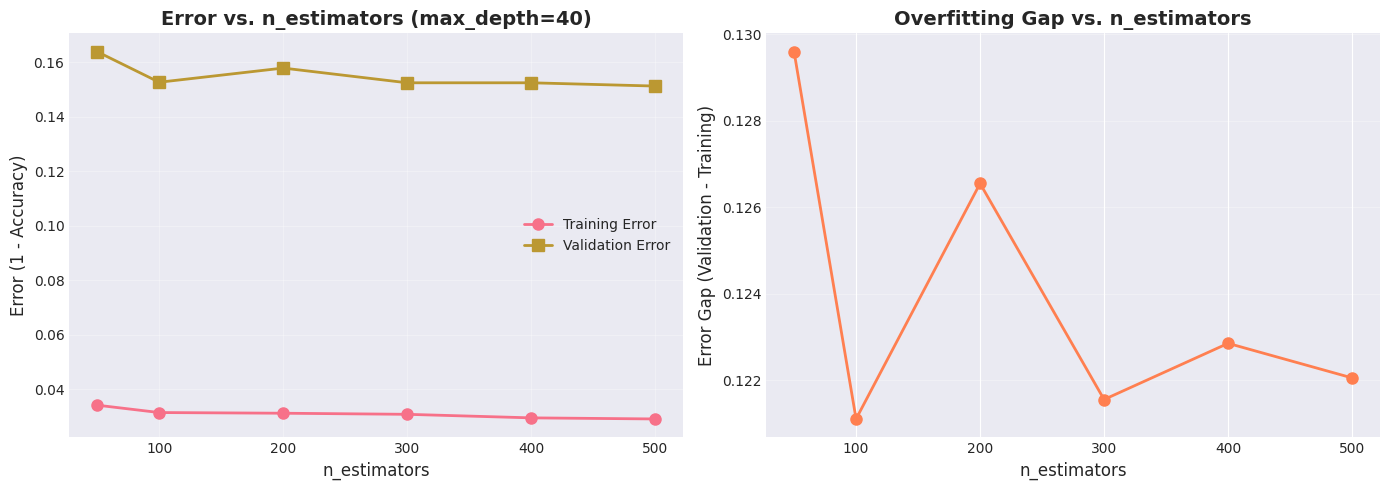

In [ ]:
n_estimators_range = [50, 100, 200, 300, 400, 500]
estimator_results = {'n_est': [], 'train_err': [], 'val_err': [], 'gap': []}

for n_est in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=best_depth,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    estimator_results['n_est'].append(n_est)
    estimator_results['train_err'].append(train_err)
    estimator_results['val_err'].append(val_err)
    estimator_results['gap'].append(gap)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(estimator_results['n_est'], estimator_results['train_err'], 'o-', 
             label='Training Error', linewidth=2, markersize=8)
axes[0].plot(estimator_results['n_est'], estimator_results['val_err'], 's-', 
             label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xlabel('n_estimators', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title(f'Error vs. n_estimators (max_depth={best_depth})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(estimator_results['n_est'], estimator_results['gap'], 'o-', 
             color='black', linewidth=2, markersize=8)
axes[1].set_xlabel('n_estimators', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. n_estimators', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

best_n_est_idx = np.argmin(estimator_results['val_err'])
best_n_est = estimator_results['n_est'][best_n_est_idx]


#### 3.6 Exploring min_samples_split


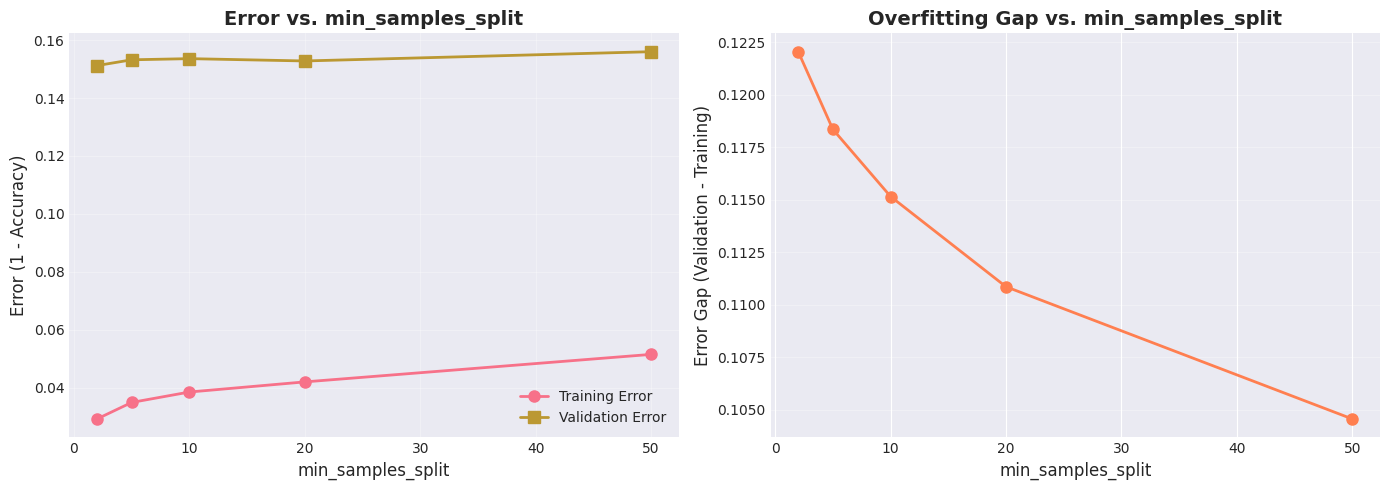

In [ ]:
min_samples_splits = [2, 5, 10, 20, 50]
split_results = []

for min_split in min_samples_splits:
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        min_samples_split=min_split,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    split_results.append({
        'value': min_split,
        'train_err': train_err,
        'val_err': val_err,
        'gap': gap
    })

best_split = min(split_results, key=lambda x: x['val_err'])
best_min_split = best_split['value']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

split_vals = [r['value'] for r in split_results]
axes[0].plot(split_vals, [r['train_err'] for r in split_results], 'o-', label='Training Error', linewidth=2, markersize=8)
axes[0].plot(split_vals, [r['val_err'] for r in split_results], 's-', label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xlabel('min_samples_split', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title('Error vs. min_samples_split', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(split_vals, [r['gap'] for r in split_results], 'o-', color='black', linewidth=2, markersize=8)
axes[1].set_xlabel('min_samples_split', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. min_samples_split', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


#### 3.7 Exploring min_samples_leaf


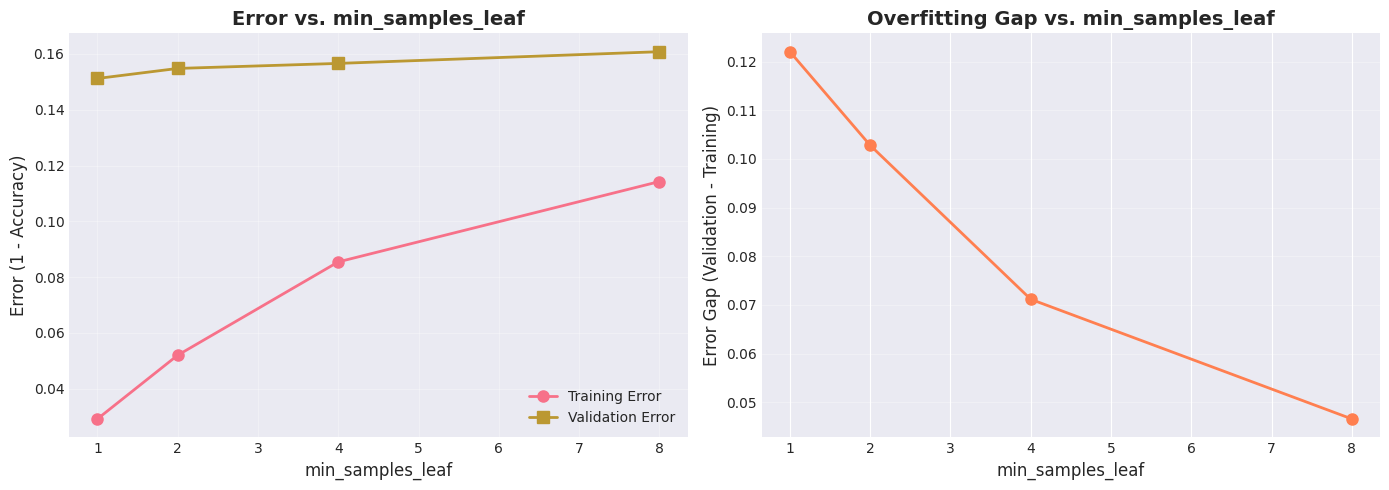

In [ ]:
min_samples_leaves = [1, 2, 4, 8]
leaf_results = []

for min_leaf in min_samples_leaves:
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        min_samples_leaf=min_leaf,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    leaf_results.append({
        'value': min_leaf,
        'train_err': train_err,
        'val_err': val_err,
        'gap': gap
    })

best_leaf = min(leaf_results, key=lambda x: x['val_err'])
best_min_leaf = best_leaf['value']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

leaf_vals = [r['value'] for r in leaf_results]
axes[0].plot(leaf_vals, [r['train_err'] for r in leaf_results], 'o-', label='Training Error', linewidth=2, markersize=8)
axes[0].plot(leaf_vals, [r['val_err'] for r in leaf_results], 's-', label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xlabel('min_samples_leaf', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title('Error vs. min_samples_leaf', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(leaf_vals, [r['gap'] for r in leaf_results], 'o-', color='black', linewidth=2, markersize=8)
axes[1].set_xlabel('min_samples_leaf', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. min_samples_leaf', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


#### 3.8 Final Optimized Model


In [ ]:

final_params = {
    'n_estimators': best_n_est,
    'max_depth': best_depth,
    'min_samples_split': best_min_split,
    'min_samples_leaf': best_min_leaf,
    'max_features': 'sqrt',
    'random_state': 1234,
    'n_jobs': -1
}

rf_optimized = RandomForestClassifier(**final_params)
rf_optimized.fit(X_train_vec, y_train_binary)

y_train_pred_opt = rf_optimized.predict(X_train_vec)
y_test_pred_opt = rf_optimized.predict(X_test_vec)

train_accuracy_opt = accuracy_score(y_train_binary, y_train_pred_opt)
test_accuracy_opt = accuracy_score(y_test_binary, y_test_pred_opt)

print(f"Final Model Parameters:")
print(f"n_estimators: {best_n_est}")
print(f"max_depth: {best_depth}")
print(f"min_samples_split: {best_min_split}")
print(f"min_samples_leaf: {best_min_leaf}")
print(f"max_features: sqrt")

print()

print(f"Final Model Performance:")
print(f"Training Accuracy: {train_accuracy_opt:.4f}")
print(f"Test Accuracy: {test_accuracy_opt:.4f}")


Final Model Parameters:
  n_estimators: 500
  max_depth: 40
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt

Final Model Performance:
  Training Accuracy: 0.9674
  Test Accuracy: 0.8500


#### 3.9 Feature Importance


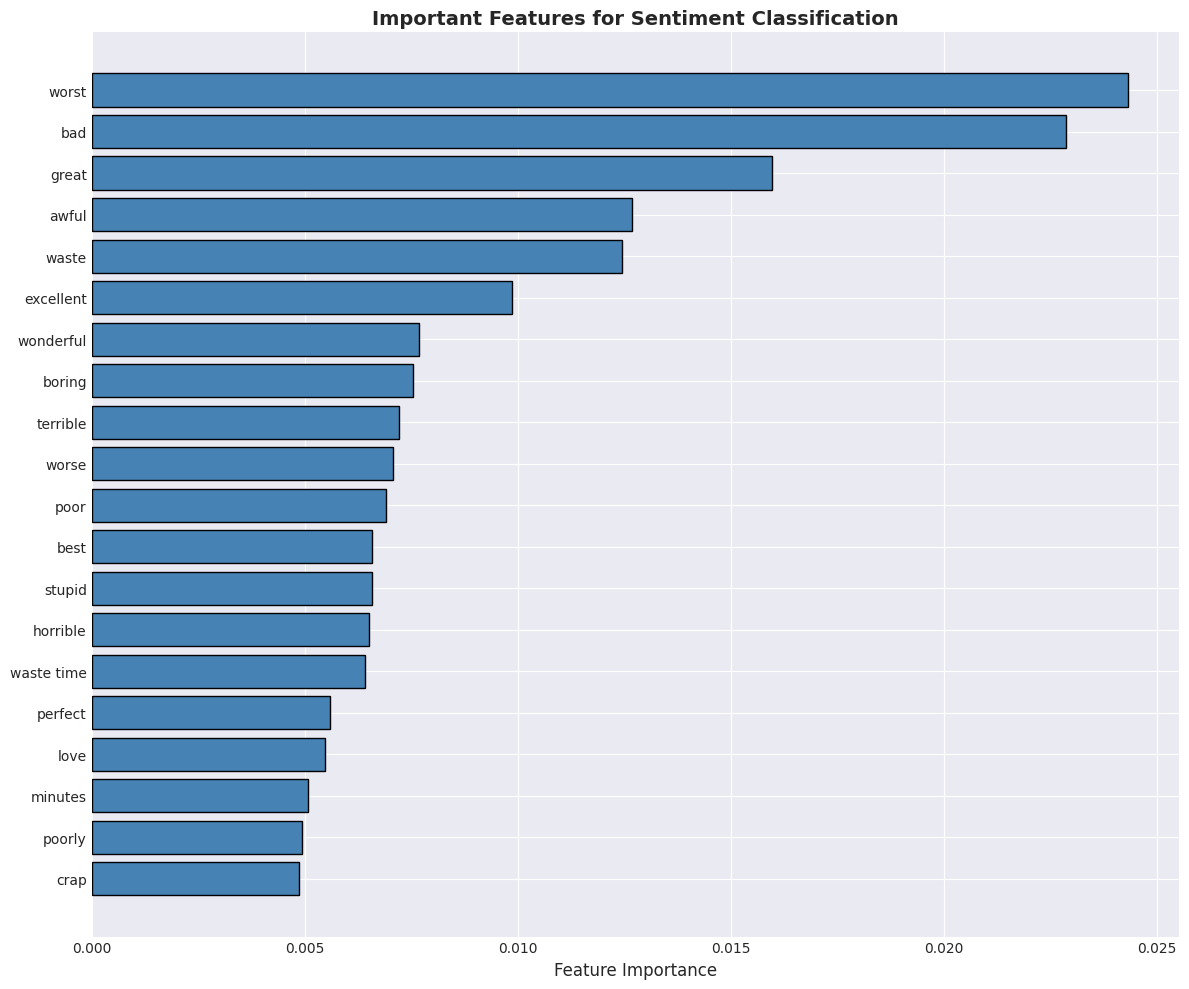

In [ ]:
feature_importance = rf_optimized.feature_importances_
top_indices = np.argsort(feature_importance)[-30:][::-1]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]

fig, ax = plt.subplots(figsize=(12, 10))
top_20_features = [f[0] for f in top_features[:20]]
top_20_importance = [f[1] for f in top_features[:20]]

ax.barh(range(len(top_20_features)), top_20_importance, color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_20_features)))
ax.set_yticklabels(top_20_features)
ax.set_xlabel('Feature (Words) Importance', fontsize=12)
ax.set_title('20 MostImportant Words for Sentiment Classification', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()



#### 3.10 Confusion Matrix


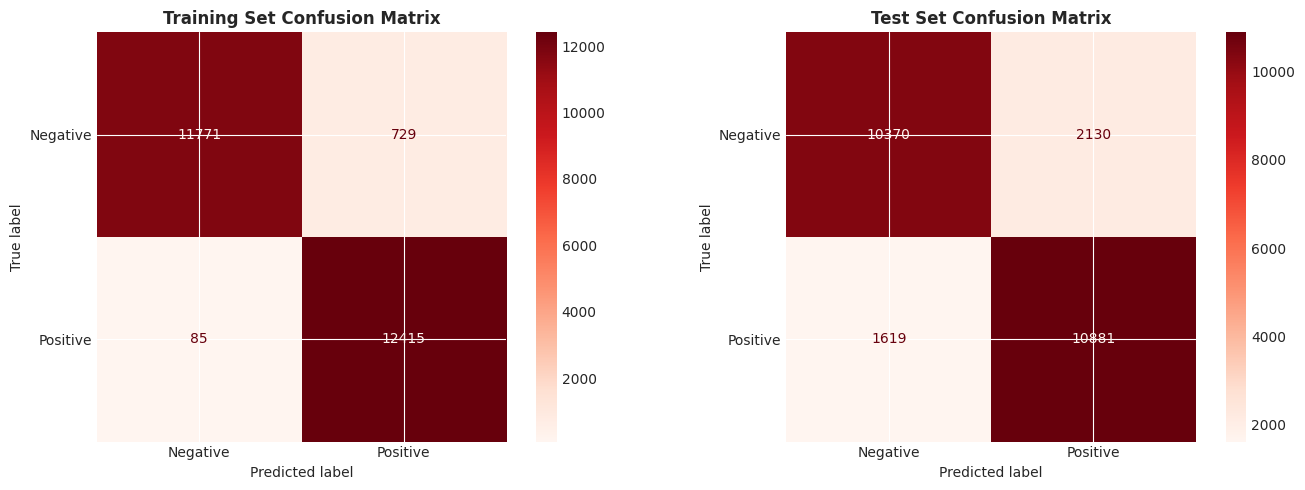

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_train_binary, y_train_pred_opt,
    display_labels=['Negative', 'Positive'],
    ax=axes[0],
    cmap='Reds',
    values_format='d'
)
axes[0].set_title('Training Set Confusion Matrix', fontsize=12, fontweight='bold')

ConfusionMatrixDisplay.from_predictions(
    y_test_binary, y_test_pred_opt,
    display_labels=['Negative', 'Positive'],
    ax=axes[1],
    cmap='Reds',
    values_format='d'
)
axes[1].set_title('Test Set Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



## 4. Additional Depth

### 4.1 Random Forest with GridSearchCV


In [54]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=1234, n_jobs=-1, verbose=0),
    param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

rf_grid.fit(X_train_subset, y_train_subset)

rf_grid_optimized = rf_grid.best_estimator_
rf_grid_optimized.fit(X_train_vec, y_train_binary)
y_test_pred_grid = rf_grid_optimized.predict(X_test_vec)
test_accuracy_grid = accuracy_score(y_test_binary, y_test_pred_grid)

print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Optimized Model Accuracy: {test_accuracy_grid:.4f}")


### 4.2 Gradient Boosting Baseline


In [55]:
from sklearn.ensemble import GradientBoostingClassifier

gb_baseline = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=1234,
    verbose=0
)

gb_baseline.fit(X_train_subset, y_train_subset)

y_test_pred_gb = gb_baseline.predict(X_test_vec)
test_accuracy_gb = accuracy_score(y_test_binary, y_test_pred_gb)

print(f"Gradient Boosting Baseline: {test_accuracy_gb:.4f}")


Gradient Boosting Baseline: 0.8215


### 4.3 Gradient Boosting with GridSearchCV


In [56]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=1234, verbose=0),
    param_grid_gb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

gb_grid.fit(X_train_subset, y_train_subset)

gb_optimized = gb_grid.best_estimator_
gb_optimized.fit(X_train_vec, y_train_binary)
y_test_pred_gb_opt = gb_optimized.predict(X_test_vec)
test_accuracy_gb_opt = accuracy_score(y_test_binary, y_test_pred_gb_opt)

print(f"Best Parameters: {gb_grid.best_params_}")
print(f"Optimized Model Accuracy: {test_accuracy_gb_opt:.4f}")


Best Parameters: {'learning_rate': 0.15, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Model Accuracy: 0.8555


### 4.4 Model Comparison


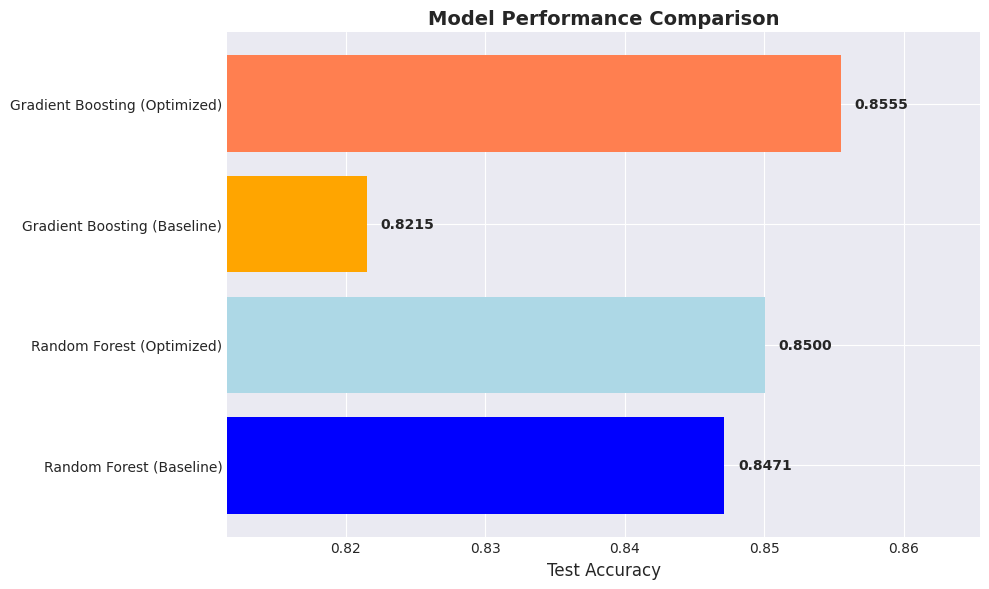

In [59]:
models_comparison = {
    'Random Forest (Baseline)': test_accuracy,
    'Random Forest (Optimized)': test_accuracy_opt,
    'Gradient Boosting (Baseline)': test_accuracy_gb,
    'Gradient Boosting (Optimized)': test_accuracy_gb_opt
}

fig, ax = plt.subplots(figsize=(10, 6))
models = list(models_comparison.keys())
accuracies = list(models_comparison.values())
colors = ['blue', 'lightblue', 'orange', 'coral']

bars = ax.barh(models, accuracies, color=colors)
ax.set_xlabel('Test Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([min(accuracies) - 0.01, max(accuracies) + 0.01])

for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(acc + 0.001, i, f'{acc:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


---

## 5. Validation, Adaptation, and Fine-tuning

### 5.1 Cross-Validation and Performance Assessment

In [68]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

gb_cv_scores = cross_val_score(gb_optimized, X_train_vec, y_train_binary, cv=cv, scoring='accuracy', n_jobs=-1)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
train_idx, val_idx = next(sss.split(X_train_vec, y_train_binary))

X_train_split = X_train_vec[train_idx]
y_train_split = y_train_binary[train_idx]
X_val_split = X_train_vec[val_idx]
y_val_split = y_train_binary[val_idx]

gb_optimized.fit(X_train_split, y_train_split)
gb_train_score = gb_optimized.score(X_train_split, y_train_split)
gb_val_score = gb_optimized.score(X_val_split, y_val_split)


### 5.2 Model Performance Analysis

Cross-Validation Results:
Mean CV Accuracy: 0.8548 (+/- 0.0091)
Individual CV Scores: [0.849  0.8572 0.861  0.8568 0.8502]

Train/Validation Split Results:
Training Accuracy: 0.9749
Validation Accuracy: 0.8474
Overfitting Gap: 0.1275


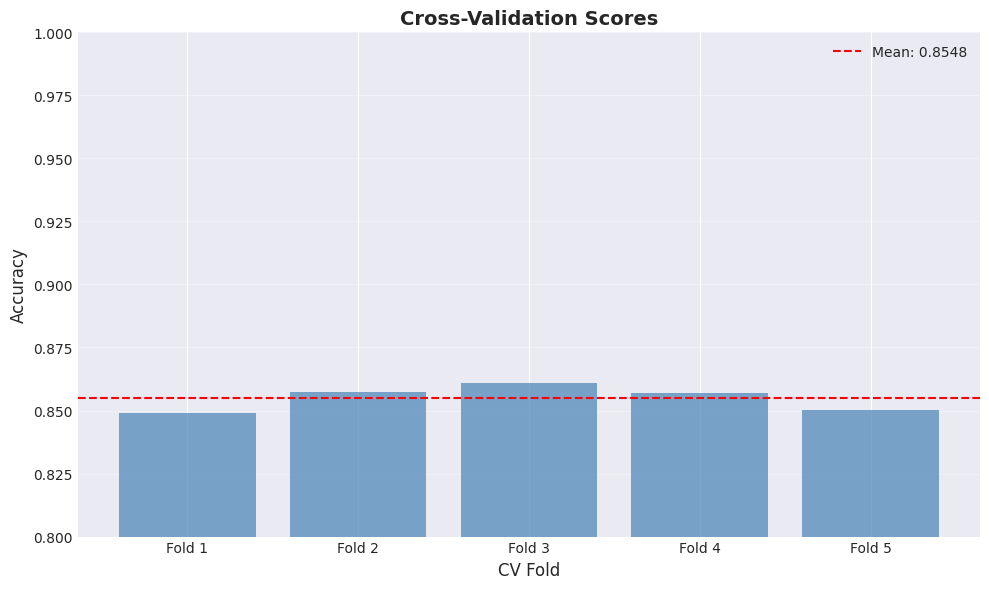

In [72]:
print("Cross-Validation Results:")
print("=" * 70)
print(f"Mean CV Accuracy: {gb_cv_scores.mean():.4f} (+/- {gb_cv_scores.std() * 2:.4f})")
print(f"Individual CV Scores: {gb_cv_scores}")

print("\n" + "=" * 70)
print("Train/Validation Split Results:")
print("=" * 70)
print(f"Training Accuracy: {gb_train_score:.4f}")
print(f"Validation Accuracy: {gb_val_score:.4f}")
print(f"Overfitting Gap: {gb_train_score - gb_val_score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(gb_cv_scores)), gb_cv_scores, color='steelblue', alpha=0.7)
plt.axhline(y=gb_cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {gb_cv_scores.mean():.4f}')
plt.xlabel('CV Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.xticks(range(len(gb_cv_scores)), [f'Fold {i+1}' for i in range(len(gb_cv_scores))])
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()


### 5.3 Model Adaptation Based on Performance Analysis


In [75]:
gb_gap = gb_train_score - gb_val_score

vectorizer_no_stop = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words=None
)

X_train_vec_no_stop = vectorizer_no_stop.fit_transform(X_train_text)
X_test_vec_no_stop = vectorizer_no_stop.transform(X_test_text)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
train_idx, val_idx = next(sss.split(X_train_vec_no_stop, y_train_binary))

X_train_split_no_stop = X_train_vec_no_stop[train_idx]
y_train_split = y_train_binary[train_idx]
X_val_split_no_stop = X_train_vec_no_stop[val_idx]
y_val_split = y_train_binary[val_idx]

gb_adapted1 = gb_optimized.__class__(**gb_optimized.get_params())
gb_adapted1.fit(X_train_split_no_stop, y_train_split)

train_acc_1 = gb_adapted1.score(X_train_split_no_stop, y_train_split)
val_acc_1 = gb_adapted1.score(X_val_split_no_stop, y_val_split)

gb_params = gb_optimized.get_params()
gb_params['learning_rate'] = max(0.01, gb_params.get('learning_rate', 0.1) * 0.7)
gb_params['min_samples_split'] = max(5, gb_params.get('min_samples_split', 2) * 2)

gb_adapted2 = gb_optimized.__class__(**gb_params)
gb_adapted2.fit(X_train_split_no_stop, y_train_split)

train_acc_2 = gb_adapted2.score(X_train_split_no_stop, y_train_split)
val_acc_2 = gb_adapted2.score(X_val_split_no_stop, y_val_split)

gb_adapted2.fit(X_train_vec_no_stop, y_train_binary)
test_acc_adapted = gb_adapted2.score(X_test_vec_no_stop, y_test_binary)

print(f"Original: Test={test_accuracy_gb_opt:.4f}, Gap={gb_gap:.4f}")
print(f"Adaptation 1 (no stop words): Train={train_acc_1:.4f}, Val={val_acc_1:.4f}, Gap={train_acc_1-val_acc_1:.4f}")
print(f"Adaptation 2 (+ regularization): Train={train_acc_2:.4f}, Val={val_acc_2:.4f}, Gap={train_acc_2-val_acc_2:.4f}, Test={test_acc_adapted:.4f}")


Original: Test=0.8555, Gap=0.1275
Adaptation 1 (no stop words): Train=0.9896, Val=0.8660, Gap=0.1236
Adaptation 2 (+ regularization): Train=0.9728, Val=0.8612, Gap=0.1116, Test=0.8620


Analysis on that...

---

## 6. Summary

### 6.1 Key Findings

### 6.2 Conclusions


### 6.3 Dataset Citation

```
@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
```
